<a href="https://colab.research.google.com/github/guchenwei57118139/26W-CS263/blob/main/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 263 Assignment 1: Transformer and LLMs for Natural Language Inference (NLI)

## Deadline: 11:59 PM, Jan 26, 2026


## Outline
- Part 1: Transformer Implementation (55 points)
- Part 2: Training and Evaluation via Huggingface Transformer (45 points)

## Instructions
- Follow the instructions and fill in the code for the sections marked with `# TODO`.
- **DO NOT** modify the checking/grading cells. Modifying these cells is strictly prohibited and will be treated as an academic integrity violation which will result in 0 score for this assignment and escalation to The Office of Student Conduct at UCLA.
- This assignment could be completed on Google Colab with the Free-Tier T4 GPU. That being said, feel free to use your own compute resources.
- We encourage you to start early, as some parts may take additional time (e.g. requesting access to a gated LLM on HuggingFace).

## Submission
- **Execution**: Ensure all cells have been run, and outputs are displayed before submission.
- **File Naming**: Save and download your completed notebook with outputs exactly as `hw1.ipynb`.
- **Upload**: Submit your `hw1.ipynb` file to Gradescope.

Failure to follow these instructions will result in the autograder failing, which will automatically result in 0 points. **No regrading will be done** for submissions with incorrect file names or formats.



## Part 1: Transformer Implementation (55 points)

### Section 1: Scaled Dot-Product Attention (15 points)

In this section, you'll implement the **generalized Scaled Dot-Product Self-Attention** mechanism as taught in the class. This is a core component of the Transformer model. This generalized version can accommodate encoder-only, decoder-only and encoder-decoder Transformer architectures, which means it supports cases where the lengths of the queries (Q) and key-value pairs (K, V) may **differ**. This is crucial for tasks like machine translation, where the encoder and decoder operate over sequences of different lengths.


This mechanism takes four inputs: queries (Q), keys (K), values (V), and attention masks. It computes attention weights based on the dot product of Q and K, scaled by the square root of the dimensionality of the keys. This helps stabilize gradients and improve model performance. Once the attention weights are calculated, they are used to combine the values (V) into a weighted sum.







In [ ]:
# DO NOT alter this cell
import torch
from torch import nn
import math
import numpy as np
from torch.nn import functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
def scaled_dot_product_attention(q, k, v, mask=None):
    # Q: FloatTensor of shape (bsz, q_len, d)
    # K, V: FloatTensor of shape (bsz, kv_len, d)
    # mask: optional, BoolTensor of shape (bsz, q_len, kv_len)
    # return: outputs, attention_weights
    #   outputs: FloatTensor of shape (bsz, q_len, d), output of attention module
    #   attention_weights: FloatTensor of shape (bsz, q_len, kv_len), attention weights between 0-1

    # Hint: if mask[i, j, k] is False, that means for the i-th data point in the batch,
    #   the attention weight from j-th position in Q to k-th position in KV is zero.
    #   To do that, you can set the attention logits to a very small value like -np.inf before feeding to softmax

    # TODO:
    # dimension d_k
    d_k = q.size(-1)

    # raw attention scores: (Q @ K^T) / sqrt(d)
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

    # Apply mask if provided
    if mask is not None:
        scores = scores.masked_fill(mask == False, -1e9)

    # Softmax
    attention_weights = torch.softmax(scores, dim=-1)

    # Multiply by V
    outputs = torch.matmul(attention_weights, v)
    return outputs, attention_weights

You can use the following section to check your implementation

In [ ]:
# DO NOT alter this cell
# Verify shape
bsz, q_len, kv_len, d = 2, 5, 4, 3
q = torch.randn(bsz, q_len, d)
k = torch.randn(bsz, kv_len, d)
v = torch.randn(bsz, kv_len, d)
values, attention = scaled_dot_product_attention(q, k, v)
print(f"the output shape is {values.shape}")
print(f"the shape of attention weight ({attention.shape}) should be the batch x query x key = {bsz} x {q_len} x {kv_len}")
assert tuple(attention.shape) == (bsz, q_len, kv_len)
print("Part 1.1.1.a passed")
print()
print("Checking that attention weights sum to 1 across the key dimension (kv_len).")
assert attention.sum(-1).allclose(torch.ones(bsz, q_len, ))
print("Part 1.1.1.b passed")
print()
print("Checking that our implementation produces the same results as PyTorch's built-in function.")
assert values.allclose(F.scaled_dot_product_attention(q, k, v, attn_mask=None))
print("Part 1.1.1.c passed")
print()
# Verify attention mask's function
bsz, q_len, kv_len, d = 2, 5, 4, 3
q = torch.randn(bsz, q_len, d)
k = torch.randn(bsz, kv_len, d)
v = torch.randn(bsz, kv_len, d)
mask = torch.rand(bsz, q_len, kv_len) > 0.5
mask[:, :, 0] = True
values, attention = scaled_dot_product_attention(q, k, v, mask=mask)
assert tuple(attention.shape) == (bsz, q_len, kv_len)
assert attention.sum(-1).allclose(torch.ones(bsz, q_len))
print("Ensuring that positions excluded by the mask have nearly zero attention values.")
assert (attention[~mask].abs() < 1e-8).all()
print("Part 1.1.2.a passed")
print()
print("Verifying that our masked attention output matches PyTorch's built-in function with the mask applied.")
assert values.allclose(F.scaled_dot_product_attention(q, k, v, attn_mask=mask))
print("Part 1.1.2.b passed")

the output shape is torch.Size([2, 5, 3])
the shape of attention weight (torch.Size([2, 5, 4])) should be the batch x query x key = 2 x 5 x 4
Part 1.1.1.a passed

Checking that attention weights sum to 1 across the key dimension (kv_len).
Part 1.1.1.b passed

Checking that our implementation produces the same results as PyTorch's built-in function.
Part 1.1.1.c passed

Ensuring that positions excluded by the mask have nearly zero attention values.
Part 1.1.2.a passed

Verifying that our masked attention output matches PyTorch's built-in function with the mask applied.
Part 1.1.2.b passed


### Section 2: Multi-head Attention (10 points)

Multi-head attention allows the model to focus on different parts of the input sequence from multiple perspectives, enhancing the model's ability to capture diverse dependencies. This is achieved by using multiple attention heads, each with its own set of query, key, and value projections. The outputs from all heads are then concatenated together.

In [ ]:
def multi_head_attention(q, k, v, num_heads: int, mask=None):
    # Q: FloatTensor of shape (bsz, q_len, d_model)
    # K, V: FloatTensor of shape (bsz, kv_len, d_model)
    # mask: optional, BoolTensor of shape (bsz, q_len, kv_len)
    # return: outputs, attention_weights
    #   outputs: FloatTensor of shape (bsz, q_len, d_model), output of attention module
    #   attention_weights: FloatTensor of shape (bsz, num_heads, q_len, kv_len), attention weights between 0-1

    # Hint: to perform multi-head attention, you split the `d_model`-dimension features into `num_heads` splits. Each attention head will use d_model // num_heads dimensions
    # Hint: For example, if d_model is 12 and num_heads is 3, then the first head uses first 4 features, the second head uses 4-8 features, and the third one use last 4 features
    # Hint: Then finally, we concatenate outputs from all heads into the output values
    # Hint: You can call the scaled_dot_product_attention function you just implemented for each head's computation
    # Hint: In real applications, we also want some linear layers to "project" the query, key and values before doing attention, but now we're omitting this step
    assert q.shape[-1] % num_heads == 0

    # TODO:
    bsz, q_len, d_model = q.size()
    kv_len = k.size(1)

    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
    d_head = d_model // num_heads

    # Split Heads
    q_heads = q.view(bsz, q_len, num_heads, d_head).transpose(1, 2)
    k_heads = k.view(bsz, kv_len, num_heads, d_head).transpose(1, 2)
    v_heads = v.view(bsz, kv_len, num_heads, d_head).transpose(1, 2)

    # Handle Mask
    if mask is not None:
        mask = mask.unsqueeze(1)

    # Calculate Attention
    attn_outputs, attention_weights = scaled_dot_product_attention(q_heads, k_heads, v_heads, mask)

    # Concatenate Heads
    attn_outputs = attn_outputs.transpose(1, 2).contiguous()

    # Flatten / Concatenate
    outputs = attn_outputs.view(bsz, q_len, d_model)
    return outputs, attention_weights


You can use the following section to check your implementation

In [ ]:
# DO NOT alter this cell

# Verify shape
bsz, q_len, kv_len, d, num_heads = 2, 5, 4, 12, 3
q = torch.randn(bsz, q_len, d)
k = torch.randn(bsz, kv_len, d)
v = torch.randn(bsz, kv_len, d)
values, attention = multi_head_attention(q, k, v, num_heads=num_heads)
print(f"the output shape is {values.shape}")
print(f"the shape of attention weight ({attention.shape}) should be the batch x number of attention heads x query x key(value) = {bsz} x {num_heads} x {q_len} x {kv_len}")
assert tuple(attention.shape) == (bsz, num_heads, q_len, kv_len)
print("Checking that attention weights sum to 1 across the key dimension (kv_len).")
assert attention.sum(-1).allclose(torch.ones(bsz, num_heads, q_len))
print("Part 1.2.1.a passed")
print()
print("Checking that our implementation produces the same results as PyTorch's built-in function.")
standard_values, standard_attention = F.multi_head_attention_forward(
    q.permute(1, 0, 2), k.permute(1, 0, 2), v.permute(1, 0, 2),
    embed_dim_to_check=d, num_heads=num_heads, attn_mask=None,
    use_separate_proj_weight=True, in_proj_weight=None, in_proj_bias=None,
    q_proj_weight=torch.eye(d), k_proj_weight=torch.eye(d), v_proj_weight=torch.eye(d),
    out_proj_weight=torch.eye(d), out_proj_bias=torch.zeros(d),
    add_zero_attn=False, dropout_p=0, is_causal=False,
    bias_k=None, bias_v=None, average_attn_weights=False,
)
assert values.allclose(standard_values.permute(1, 0, 2))
assert attention.allclose(standard_attention)
print("Part 1.2.1.b passed")
print()
# Verify attention mask's function
bsz, q_len, kv_len, d, num_heads = 2, 5, 4, 12, 3
q = torch.randn(bsz, q_len, d)
k = torch.randn(bsz, kv_len, d)
v = torch.randn(bsz, kv_len, d)
mask = torch.rand(bsz, q_len, kv_len) > 0.5
mask[:, :, 0] = True
values, attention = multi_head_attention(q, k, v, num_heads=num_heads, mask=mask)
assert tuple(attention.shape) == (bsz, num_heads, q_len, kv_len)
assert attention.sum(-1).allclose(torch.ones(bsz, num_heads, q_len))
print("Part 1.2.2.a passed")
print()

print("Ensuring that positions excluded by the mask have nearly zero attention values.")
assert (attention.sum(1)[~mask].abs() < 1e-8).all()
standard_values, standard_attention = F.multi_head_attention_forward(
    q.permute(1, 0, 2), k.permute(1, 0, 2), v.permute(1, 0, 2),
    embed_dim_to_check=d, num_heads=num_heads, attn_mask=(~mask).repeat_interleave(num_heads, dim=0),
    use_separate_proj_weight=True, in_proj_weight=None, in_proj_bias=None,
    q_proj_weight=torch.eye(d), k_proj_weight=torch.eye(d), v_proj_weight=torch.eye(d),
    out_proj_weight=torch.eye(d), out_proj_bias=torch.zeros(d),
    add_zero_attn=False, dropout_p=0, is_causal=False,
    bias_k=None, bias_v=None, average_attn_weights=False,
)
print("Verifying that our masked attention output matches PyTorch's built-in function with the mask applied.")
assert values.allclose(standard_values.permute(1, 0, 2))
assert attention.allclose(standard_attention)
print("Part 1.2.2.b passed")
print()


the output shape is torch.Size([2, 5, 12])
the shape of attention weight (torch.Size([2, 3, 5, 4])) should be the batch x number of attention heads x query x key(value) = 2 x 3 x 5 x 4
Checking that attention weights sum to 1 across the key dimension (kv_len).
Part 1.2.1.a passed

Checking that our implementation produces the same results as PyTorch's built-in function.
Part 1.2.1.b passed

Part 1.2.2.a passed

Ensuring that positions excluded by the mask have nearly zero attention values.
Verifying that our masked attention output matches PyTorch's built-in function with the mask applied.
Part 1.2.2.b passed



Below is an overall architecture of transformer.

In [ ]:
class MultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.q_proj.weight)
        nn.init.xavier_uniform_(self.k_proj.weight)
        nn.init.xavier_uniform_(self.v_proj.weight)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.q_proj.bias.data.fill_(0)
        self.k_proj.bias.data.fill_(0)
        self.v_proj.bias.data.fill_(0)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None):
        q = self.q_proj(x)  # Note: for actual implementation, we need to do projection
        k = self.k_proj(x)
        v = self.v_proj(x)
        o, _ = multi_head_attention(q, k, v, self.num_heads, mask=mask)
        return self.o_proj(o)


class DecoderBlock(nn.Module):
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x


class TransformerDecoder(nn.Module):
    def __init__(self, we, pe, layers):
        super().__init__()
        self.we = we  # word embeddings
        self.pe = pe  # positional embeddings
        self.layers = nn.ModuleList(layers)
        vocab_size, model_dim = we.weight.shape
        self.lm_head = nn.Linear(model_dim, vocab_size, bias=False)

    def forward(self, tokens, mask=None):
        x = self.we(tokens) + self.pe(tokens)
        for l in self.layers:
            x = l(x, mask=mask)
        logits = self.lm_head(x)
        return logits

### Section 3: Positional Encoding (10 points)

Transformers lack an inherent sense of order in sequences, which is why positional encodings are added to the input embeddings. These encodings provide information about the position of tokens in a sequence, allowing the model to differentiate between tokens in different positions.

The positional encoding for each element $PE(pos, 2i)$ and $PE(pos, 2i+1)$ is defined as follows:

$$
\begin{align}
    PE(pos, 2i) & = \sin(\frac{pos}{10000^{\frac{2i}{d_{model}}}}), \\
    PE(pos, 2i+1) & = \cos(\frac{pos}{10000^{\frac{2i}{d_{model}}}})
\end{align}
$$

where:
- $pos$ is the position in the sequence.
- $i$ is the dimension index (split between even and odd indices).
- $d_{model}$ is the dimensionality of the model's input embeddings.

This alternating use of sine and cosine allows each position to have a unique encoding across the dimensions, making it easier for the model to distinguish between positions.


In [ ]:
class PositionalEncodings(nn.Module):
    def __init__(self, d_model, base=10000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            base - Base for rotary positional encodings.
        """
        super().__init__()
        self.d_model = d_model
        self.base = base

    def forward(self, x):
        # x: FloatTensor of shape (bsz, seq_len)
        # return: pe, FloatTensor of shape (bsz, seq_len, d_model)
        #   pe[..., i] is the positional encoding for i-th position
        bsz, seq_len = x.shape

        # TODO:
        bsz, seq_len = x.shape

        # Position Indices
        position = torch.arange(seq_len, dtype=torch.float, device=x.device).unsqueeze(1)

        # Div Term
        div_term = torch.exp(
            torch.arange(0, self.d_model, 2, dtype=torch.float, device=x.device) * -(math.log(self.base) / self.d_model)
        )

        # seq_len, d_model
        pe = torch.zeros(seq_len, self.d_model, device=x.device)

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0).expand(bsz, -1, -1)
        return pe.to(x.device)

In [ ]:
# DO NOT alter this cell
d_model = 64

pe = PositionalEncodings(d_model).forward(torch.zeros(1, 100)).squeeze(0)
print(f"The shape of positional encoding {pe.shape} should be sequence length x feature dimension = 100 x {d_model}")
assert tuple(pe.shape) == (100, d_model)
print("Part 1.3.1 passed")
print()
print("The difference between encodings at different positions should be non-zero, which indicates that each position has a unique encoding")
diff = (pe[:, None, :] - pe[None, :, :]).abs().sum(dim=-1)
assert (diff[~torch.eye(100).bool()] != 0).all()
print("Part 1.3.2 passed")


The shape of positional encoding torch.Size([100, 64]) should be sequence length x feature dimension = 100 x 64
Part 1.3.1 passed

The difference between encodings at different positions should be non-zero, which indicates that each position has a unique encoding
Part 1.3.2 passed


In [ ]:
# DO NOT alter this cell

n_vocab = 6
d_model = 64
num_heads = 4
n_layers = 4

model = TransformerDecoder(
    we=nn.Embedding(n_vocab, d_model),
    pe=PositionalEncodings(d_model),
    layers=[
        DecoderBlock(d_model, num_heads, dim_feedforward=2 * d_model)
        for _ in range(n_layers)
    ],
).cuda()
print(model)

tokens = torch.LongTensor([
    [0, 1, 2, 3],
    [3, 2, 1, 0],
]).cuda()
out = model(tokens)
print(f"The output shape is {out.shape}. The expected output shape is batch_size x sequence_length x vocab_size = 2 x 4 x {n_vocab}")
assert tuple(out.shape) == (tokens.shape[0], tokens.shape[1], n_vocab)

TransformerDecoder(
  (we): Embedding(6, 64)
  (pe): PositionalEncodings()
  (layers): ModuleList(
    (0-3): 4 x DecoderBlock(
      (self_attn): MultiheadAttention(
        (q_proj): Linear(in_features=64, out_features=64, bias=True)
        (k_proj): Linear(in_features=64, out_features=64, bias=True)
        (v_proj): Linear(in_features=64, out_features=64, bias=True)
        (o_proj): Linear(in_features=64, out_features=64, bias=True)
      )
      (linear_net): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): Dropout(p=0.0, inplace=False)
        (2): ReLU(inplace=True)
        (3): Linear(in_features=128, out_features=64, bias=True)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (lm_head): Linear(in_features=64, out_features=6, bias=False)
)
The output shape is torch.Size([2, 4, 6]). Th

### Section 4: Autoregressive Attention Mask (5 points)

In this function, you will implement an autoregressive attention mask, which is essential for language modeling tasks where each token can only attend to itself and the tokens that precede it. This prevents the model from "peeking" at future tokens, thus preserving the autoregressive property of the model.

The autoregressive attention mask (also called as causal attention mask) should be a lower triangular matrix. In other words, the mask is True for positions on or below the diagonal and False for positions above the diagonal

In [ ]:
def autoregressive_attention_mask(tokens):
    # tokens: (bsz, seq_len)
    # return: mask, torch.BoolTensor of shape (bsz, seq_len as q_len, seq_len as kv_len)
    # Hint: generate an autoregressive attention mask. mask[i, j, k] is True means j-th token can attend to k-th token
    #   For autoregressive language modelling task, each position can only attend to itself and its previous tokens, and cannot "cheat" and peak future tokens
    bsz, seq_len = tokens.shape

    # TODO:
    bsz, seq_len = tokens.shape
    # ones shape: (seq_len, seq_len)
    ones = torch.ones((seq_len, seq_len), device=tokens.device, dtype=torch.bool)
    mask = torch.tril(ones)

    # (seq_len, seq_len) -> (1, seq_len, seq_len) -> (bsz, seq_len, seq_len)
    mask = mask.unsqueeze(0).expand(bsz, -1, -1)
    return mask.to(tokens.device)

In [ ]:
# DO NOT alter this cell

mask = autoregressive_attention_mask(torch.zeros(2, 10))
print(f"Checking shape: expected (2, 10, 10), got {mask.shape}")
assert tuple(mask.shape) == (2, 10, 10)
print(f"Checking data type: expected torch.bool, got {mask.dtype}")
assert mask.dtype == torch.bool
for i in range(10):
    for j in range(10):
        if i >= j:
            assert mask[:, i, j].all()
        else:
            assert not mask[:, i, j].any()

print("Part 1.4 passed")

Checking shape: expected (2, 10, 10), got torch.Size([2, 10, 10])
Checking data type: expected torch.bool, got torch.bool
Part 1.4 passed


### Section 5: Language Modeling Objective (15 points)

The language modeling loss is commonly used in tasks where the goal is to predict the next word in a sequence. This loss measures the difference between the predicted probabilities of the model and the actual word in the sequence. For this task, cross-entropy loss is often used as it compares the predicted distribution with the true one-hot encoded distribution.
Note: Since we are doing next token predictions, **Remember to shift the tokens to get the actual labels**

In [ ]:
def language_modelling_loss(tokens, logits):
    # tokens: (bsz, seq_len)
    # logits: (bsz, seq_len, n_vocab) raw logits predicted from `logits = self.lm_head(x)`
    # return: loss, a torch scalar.
    # Hint: use https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
    #   Since language modelling is essentially a self supervision task, you can create labels from input tokens itself
    #   Remember to shift the tokens to get the actual labels

    # TODO:
    # Shape: (bsz, seq_len-1, n_vocab)
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = tokens[:, 1:].contiguous()
    # Flatten
    loss_fct = nn.CrossEntropyLoss()
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    return loss


In [ ]:
# DO NOT alter this cell

loss = language_modelling_loss(tokens, out)
print(f"Checking if the loss is a scalar. Expected shape: (), got {loss.shape}")

assert tuple(loss.shape) == ()
print("Part 1.5.1 passed")

Checking if the loss is a scalar. Expected shape: (), got torch.Size([])
Part 1.5.1 passed


Now let's train our implemented Transformer with a naive task: predicting the next number

/tmp/ipython-input-785691618.py:11: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  return float(loss)


Step 1: loss = 1.7995
Step 101: loss = 0.0819
Step 201: loss = 0.0336
Step 301: loss = 0.0217
Step 401: loss = 0.0160
Step 501: loss = 0.0126
Step 601: loss = 0.0102
Step 701: loss = 0.0086
Step 801: loss = 0.0073
Step 901: loss = 0.0062


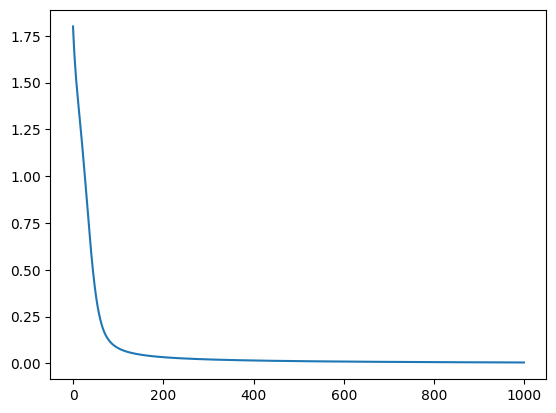

In [ ]:
# DO NOT alter this cell

def train_step(model, optimizer, tokens):
    model.zero_grad()
    model.train()
    mask = autoregressive_attention_mask(tokens)
    logits = model(tokens, mask)
    loss = language_modelling_loss(tokens, logits)
    loss.backward()
    optimizer.step()
    return float(loss)


# Let's use a very naive data to try training: predict the next number
tokens = torch.LongTensor([
    [0, 1, 2, 3],
    [1, 2, 3, 4],
    [2, 3, 4, 5],
    [5, 4, 3, 2],
    [4, 3, 2, 1],
    [3, 2, 1, 0],
]).cuda()

# re-initialize the model, in case the cell is executed multiple times
model = TransformerDecoder(
    we=nn.Embedding(n_vocab, d_model),
    pe=PositionalEncodings(d_model),
    layers=[
        DecoderBlock(d_model, num_heads, dim_feedforward=2 * d_model)
        for _ in range(n_layers)
    ],
).cuda()

# train
optimizer = optim.Adam(model.parameters(), lr=1e-4)
losses = []
for i in range(1000):
    loss = train_step(model, optimizer, tokens)
    if i % 100 == 0:
        print("Step {:d}: loss = {:.4f}".format(i + 1, loss))
    losses.append(loss)
plt.plot(losses)
plt.show()

In [ ]:
# DO NOT alter this cell

tokens = torch.LongTensor([
    [1, 2, 3],
    [3, 2, 1],
]).cuda()
mask = autoregressive_attention_mask(tokens)
logits = model(tokens, mask)
prob = nn.Softmax(dim=-1)(logits)

print("Next token of 1, 2, 3:")
for j in prob[0, -1].argsort(descending=True)[:3]:
    print("  p({:d}) = {:.4f}".format(j, prob[0, -1, j]))
assert (prob[0, -1].argsort(descending=True)[0] == 4)
print("Part 1.5.2.a passed")
print()
print("Next token of 3, 2, 1:")
for j in prob[1, -1].argsort(descending=True)[:3]:
    print("  p({:d}) = {:.4f}".format(j, prob[1, -1, j]))
assert (prob[1, -1].argsort(descending=True)[0] == 0)
print()
print("Part 1.5.2.b passed")

Next token of 1, 2, 3:
  p(4) = 0.9941
  p(1) = 0.0015
  p(3) = 0.0013
Part 1.5.2.a passed

Next token of 3, 2, 1:
  p(0) = 0.9925
  p(5) = 0.0026
  p(2) = 0.0014

Part 1.5.2.b passed


In [ ]:
# run this cell before moving into part2 to clear up gpu memory
del model
import torch
torch.cuda.empty_cache()

## Part 2: Training and Evaluation via Huggingface Transformer (45 points)

In this part, you will first implement the evaluation of a transformer model on a dataset and then fine-tune the model to observe improvements on task performance.

Hints:
- You can use a GPU to speed up the training process. Select "Runtime" > "Change runtime type" > "GPU" in the Colab settings.
- Use smaller batch sizes if you encounter memory issues.

### Prerequisites: Install Libraries and Login to HuggingFace

- The model we are going to use is [Llama-3.2-1B-Instruct](https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct) which is a gated model. Please visit the model page on Hugging Face and accept the terms of the license. Typically, access is granted within 24 hours.
- Go to huggingface -> Profile icon on the upper-right corner -> "Settings" -> "Access Tokens" to get the key for logging in

In [ ]:
!pip install transformers accelerate bitsandbytes>0.37.0 trl==0.12.0 peft
!pip install flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 96.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.8.3-cp312-cp312-linux_x86_64.whl size=253780426 sha256=4e2f9e39313266b1544b68138b15b91ee6221eccf14f7902b7c6620351340810
  Stored in directory: /root/.cache/pip/wheels/3d/59/46/f282c12c73dd4bb3c2e3fe199f1a0d0f8cec06df0cccfeee27
Successfully built flash-attn


In [3]:
from huggingface_hub import notebook_login
notebook_login()

### Section 1: Loading the model and the tokenizer (15 points)
In this section, you will learn how to load the pre-trained model and its associated tokenizer using the huggingface package.

You can see a demo code here: <br>
https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct


In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "meta-llama/Llama-3.2-1B-Instruct"
device = "cuda" if torch.cuda.is_available() else "cpu"

# TODO: Load the model using the appropriate parameters using AutoModelForCausalLM
# Ensure torch_dtype is set to torch.bfloat16
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

# TODO: Initialize the tokenizer using AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_id)

tokenizer.pad_token = tokenizer.eos_token


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [5]:
# DO NOT alter this cell.
vocab_size = len(tokenizer.get_vocab())
print(f"\nThe vocabulary size of the model is {vocab_size}")
assert vocab_size == 128256
print("Part 2.1.1 passed")


The vocabulary size of the model is 128256
Part 2.1.1 passed


In [6]:
# TODO: Define the messages for the chatbot interaction (List[Dict])
messages = [
    {"role": "system", "content": "You are a chatbot who responds very shortly."},
    {"role": "user", "content": "What country does Los Angeles belong to?"},
]

def run_model(model, tokenizer, messages, max_new_tokens=5, verbose=False):
    # TODO: Prepare the input text using the tokenizer's apply_chat_template (Do not tokenize the text yet)
    input_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    if verbose: print("\n###input_text:###\n", input_text)
    # TODO: Tokenize the input text and transfer it to the appropriate device
    inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
    input_ids = inputs.input_ids
    if verbose: print("\n###input_ids:###\n", input_ids)
    # TODO: Generate a response using the model. Ensure do_sample is False.

    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False
    )
    # TODO: Decode the output and return the response without special tokens

    generated_tokens = outputs[0][input_ids.shape[1]:]

    assistant_response = tokenizer.decode(generated_tokens, skip_special_tokens=True)
    if verbose: print("\n###response:###\n", assistant_response)
    return assistant_response

assistant_response = run_model(model=model, tokenizer=tokenizer, messages=messages, max_new_tokens=10, verbose=True)
print(f"\n###Assistant response:###\n{assistant_response}")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



###input_text:###
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 16 Jan 2026

You are a chatbot who responds very shortly.<|eot_id|><|start_header_id|>user<|end_header_id|>

What country does Los Angeles belong to?<|eot_id|><|start_header_id|>assistant<|end_header_id|>



###input_ids:###
 tensor([[128000, 128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,
           2696,     25,   6790,    220,   2366,     18,    198,  15724,   2696,
             25,    220,    845,   4448,    220,   2366,     21,    271,   2675,
            527,    264,   6369,   6465,    889,  31680,   1633,  20193,     13,
         128009, 128006,    882, 128007,    271,   3923,   3224,   1587,   9853,
          12167,   9352,    311,     30, 128009, 128006,  78191, 128007,    271]],
       device='cuda:0')

###response:###
 United States

###Assistant response:###
United States


Use the following code snippet to verify your implementation

In [7]:
# DO NOT alter this cell.
grading_messages = [
    {"role": "system", "content": "You are a chatbot who responds very shortly."},
    {"role": "user", "content": "When was UCLA founded?"},
]
grading_output = run_model(model=model, tokenizer=tokenizer, messages=grading_messages, max_new_tokens=100)
expected_output = "University of California, Los Angeles (UCLA) was founded in 1919."
print(f"Your output is: {grading_output}\nThe expected output is: {expected_output}")
if grading_output != expected_output:
    raise ValueError(f"FAILED: Incorrect response! \n\n{grading_output}\n\n{expected_output}")
print("Part 2.1.2 passed")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Your output is: University of California, Los Angeles (UCLA) was founded in 1919.
The expected output is: University of California, Los Angeles (UCLA) was founded in 1919.
Part 2.1.2 passed


### Section 2: Evaluation of the pre-trained model (15 points)
In this section, we are going to evaluate the pre-trained model with the natural language inference (NLI) task. NLI is a fundamental task in natural language processing that involves determining the relationship between two sentences: a **premise** and a **hypothesis**. The task is to classify this relationship into one of three categories:

**Entailment**: The hypothesis logically follows from the premise.

**Contradiction**: The hypothesis is logically inconsistent with the premise.

**Neutral**: This occurs when there is no clear logical relationship between the premise and the hypothesis.

You can view examples for each category by running the cell below.

Your task is to implement the evaluation code. This involves running the model on the test set and comparing its predictions with the true labels. The goal is to achieve an accuracy of at least 25% by prompt engineering the model to generate the appropriate labels for this dataset.

In [8]:
import pandas as pd
pd.set_option("display.max_colwidth", None)

# Downloading dataset
dataset = {
    "train": pd.read_json("hf://datasets/marslabucla/CS263-nli/assignment_1/esnli_train.jsonl", lines=True),
    "validation": pd.read_json("hf://datasets/marslabucla/CS263-nli/assignment_1/esnli_validation.jsonl", lines=True),
    "test": pd.read_json("hf://datasets/marslabucla/CS263-nli/assignment_1/esnli_test.jsonl", lines=True),
}

dataset["test"]

,premise,hypothesis,label
0,A nighttime street scene of a restaurant.,A nighttime scene of an apartment building.,contradiction
1,A man wearing protective gear grinds down a large metal object.,There is a man working.,entailment
2,A boy toddler is holding a bat he is about to swing at a pinata.,A child is crying because he didn't get cake,contradiction
3,A crowd of people at a county fair watch three men agitate a large bull.,A man rides horseback in the field.,contradiction
4,An older gentleman looks at the camera while he is building a deck.,A human looks at the camera while building something.,entailment
...,...,...,...
195,A shirtless man with a white hat and no shoes sitting crisscross with his back against the wall holding up a white plastic cup.,A man is waiting for someone,neutral
196,Two men wearing red jackets are looking out over some water and one man has yellow earphones on his ears.,Two women are staring at a mountain and neither has any headphones or jackets.,contradiction
197,a young girl looking down through some leaves from atop a tree.,The girl is playing hide and seek.,neutral
198,A woman wearing glasses and a brown beanie next to a girl with long brown hair holding a book.,A woman is wearing glasses and a brown beanie.,entailment


In [11]:
def apply_esnli_prompt(premise, hypothesis):
    # TODO:
    # Write a prompt for esnli dataset using given premise and hypothesis
    # so that the model classifies the input as entailment, neutral, or contradiction
    prompt = f"""Premise: {premise}
    Hypothesis: {hypothesis}

    Please determine the relationship between the premise and the hypothesis.
    Select one of the following labels: entailment, neutral, contradiction.

    Label:"""
    return prompt.strip()

In [12]:
# Applying your prompt template on the dataset
prompt_dataset = {}
for part in dataset.keys():
    prompt_dataset[part] = dataset[part].copy()
    prompt_dataset[part]["prompt"] = prompt_dataset[part].apply(lambda x: apply_esnli_prompt(x["premise"], x["hypothesis"]), axis=1)
prompt_dataset["test"]

,premise,hypothesis,label,prompt
0,A nighttime street scene of a restaurant.,A nighttime scene of an apartment building.,contradiction,"Premise: A nighttime street scene of a restaurant.\n Hypothesis: A nighttime scene of an apartment building.\n\n Please determine the relationship between the premise and the hypothesis. \n Select one of the following labels: entailment, neutral, contradiction.\n\n Label:"
1,A man wearing protective gear grinds down a large metal object.,There is a man working.,entailment,"Premise: A man wearing protective gear grinds down a large metal object.\n Hypothesis: There is a man working.\n\n Please determine the relationship between the premise and the hypothesis. \n Select one of the following labels: entailment, neutral, contradiction.\n\n Label:"
2,A boy toddler is holding a bat he is about to swing at a pinata.,A child is crying because he didn't get cake,contradiction,"Premise: A boy toddler is holding a bat he is about to swing at a pinata.\n Hypothesis: A child is crying because he didn't get cake\n\n Please determine the relationship between the premise and the hypothesis. \n Select one of the following labels: entailment, neutral, contradiction.\n\n Label:"
3,A crowd of people at a county fair watch three men agitate a large bull.,A man rides horseback in the field.,contradiction,"Premise: A crowd of people at a county fair watch three men agitate a large bull.\n Hypothesis: A man rides horseback in the field.\n\n Please determine the relationship between the premise and the hypothesis. \n Select one of the following labels: entailment, neutral, contradiction.\n\n Label:"
4,An older gentleman looks at the camera while he is building a deck.,A human looks at the camera while building something.,entailment,"Premise: An older gentleman looks at the camera while he is building a deck.\n Hypothesis: A human looks at the camera while building something.\n\n Please determine the relationship between the premise and the hypothesis. \n Select one of the following labels: entailment, neutral, contradiction.\n\n Label:"
...,...,...,...,...
195,A shirtless man with a white hat and no shoes sitting crisscross with his back against the wall holding up a white plastic cup.,A man is waiting for someone,neutral,"Premise: A shirtless man with a white hat and no shoes sitting crisscross with his back against the wall holding up a white plastic cup.\n Hypothesis: A man is waiting for someone\n\n Please determine the relationship between the premise and the hypothesis. \n Select one of the following labels: entailment, neutral, contradiction.\n\n Label:"
196,Two men wearing red jackets are looking out over some water and one man has yellow earphones on his ears.,Two women are staring at a mountain and neither has any headphones or jackets.,contradiction,"Premise: Two men wearing red jackets are looking out over some water and one man has yellow earphones on his ears.\n Hypothesis: Two women are staring at a mountain and neither has any headphones or jackets.\n\n Please determine the relationship between the premise and the hypothesis. \n Select one of the following labels: entailment, neutral, contradiction.\n\n Label:"
197,a young girl looking down through some leaves from atop a tree.,The girl is playing hide and seek.,neutral,"Premise: a young girl looking down through some leaves from atop a tree.\n Hypothesis: The girl is playing hide and seek.\n\n Please determine the relationship between the premise and the hypothesis. \n Select one of the following labels: entailment, neutral, contradiction.\n\n Label:"
198,A woman wearing glasses and a brown beanie next to a girl with long brown hair holding a book.,A woman is wearing glasses and a brown beanie.,entailment,"Premise: A woman wearing glasses and a brown beanie next to a girl with long brown hair holding a book.\n Hypothesis: A woman is wearing glasses and a brown beanie.\n\n Please determine the relationship between the premise and the hypothesis. \n Sel

In [15]:
type(prompt_dataset["test"])

pandas.core.frame.DataFrame

In [18]:
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

def evaluate_esnli(model, tokenizer, test_dataset):
    """
    Evaluate the model on the test dataset.
    Returns:
        accuracy: The accuracy of the model on the test dataset. The value is scaled from 0.0 to 1.0 (float)
        outputs: The model's predictions on the test dataset. (list[str])
    """
    # TODO: Implement the evaluation loop and return accuracy of the model as well as list of outputs
    # Hint: You can reuse the run_model function we implemented earlier.
    correct_count = 0
    total_count = len(test_dataset)
    outputs = []

    for index, row in tqdm(test_dataset.iterrows(), total=total_count, desc="Evaluating"):

        premise = row['premise']
        hypothesis = row['hypothesis']
        true_label = str(row['label'])

        prompt_text = apply_esnli_prompt(premise, hypothesis)

        messages = [
            {"role": "system", "content": "You are a chatbot who responds very shortly."},
            {"role": "user", "content": prompt_text}
        ]

        prediction = run_model(model, tokenizer, messages, max_new_tokens=5, verbose=False)

        clean_prediction = prediction.strip().lower()

        clean_prediction = clean_prediction.strip(".,!?:")

        outputs.append(clean_prediction)


        if true_label in clean_prediction:
            correct_count += 1

        if clean_prediction == true_label:
            correct_count += 1

    accuracy = correct_count / total_count if total_count > 0 else 0.0
    print(f'Evaluation Acc. {accuracy}')
    return accuracy, outputs

In [19]:
# DO NOT alter this cell:
acc, outputs = evaluate_esnli(model, tokenizer, prompt_dataset["test"])
print(f"Accuracy: {acc}")
prompt_dataset["test"]["output"] = outputs
expected_acc = 0.25
if acc < expected_acc / 2 or acc > 1:
  raise ValueError(f"FAILED: Low Accuracy! \n\n{acc} is lower than the required threshold 0.25\nYou might need to update your prompt so that the model follows the instructions better.")
print("Part 2.2.1 passed")

if acc < expected_acc or acc > 1:
    raise ValueError(f"FAILED: Low Accuracy! \n\n{acc} is lower than the required threshold {expected_acc}\nYou might need to update your prompt so that the model follows the instructions better.")
print("Part 2.2.2 passed")

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Evaluation Acc. 0.455
Accuracy: 0.455
Part 2.2.1 passed
Part 2.2.2 passed


### Section 3: NLI with Explanations (15 points)


* In this section, you'll use the e-SNLI dataset, which includes free-form rationales (explanations) for each NLI example. The task is to generate model explanations for a subset of the test set and compare them to human explanations using the BLEU score. Your primary task is to write effective prompts that will guide the model to generate explanations for a subset of the test set.

* Expectations:
    * Pretrained Model: Expected BLEU score > 0.15.

* To improve the model's explanations, you'll need to engage in prompt engineering. Adjust your input prompts to guide the model toward better explanations (More similar to human references) and aim to improve the BLEU score. You are also encouraged to check the generated explanations to qualitatively understand their quality, and possibly conduct some analysis.

* By the end of this section, you should be able to create effective prompts that improve the quality of the model's explanations and analyze their performance through BLEU scores, and optionally do a qualitative analysis by reviewing the explanations and comparing them with human-provided ones.



In [20]:
explanation_dataset = pd.read_json("hf://datasets/marslabucla/CS263-nli/assignment_1/esnli_test_with_explanation.jsonl", lines=True)
explanation_dataset

,premise,hypothesis,label,explanation_1,explanation_2,explanation_3
0,A nighttime street scene of a restaurant.,A nighttime scene of an apartment building.,contradiction,"The scene is of a restaurant, which is not an apartment building.",Scene can't be of apartment building if it is a restaurant.,The scene can be either an apartment building or a restaurant.
1,A man wearing protective gear grinds down a large metal object.,There is a man working.,entailment,Grinds down implies working.,Grinding down a large metal object implies the man is working.,The man is working by grinding down on a large metal object.
2,A boy toddler is holding a bat he is about to swing at a pinata.,A child is crying because he didn't get cake,contradiction,A toddler can be either holding a bat or crying.,A boy toddler indicates the gender is male and the age is 1-3 years old whereas a child could be male or female and up to 12 or 13 years of age generally. Holding a bat to swing at a pinata implies the child is happy and having fun whereas crying implies that the child is sad.,A boy that is about to swing at a pinata cannot be crying because he didn't get cake.
3,A crowd of people at a county fair watch three men agitate a large bull.,A man rides horseback in the field.,contradiction,Three men is not the same as a man.,Three men agitate a large bull is not the same as a single man rides horseback.,There is only one man riding horseback in a field not a crowd of people at a county fair with a large bull.
4,An older gentleman looks at the camera while he is building a deck.,A human looks at the camera while building something.,entailment,An older gentleman is a human as well.,"If it is a man, or gentleman, that is a human.",The creature is a human because he is a gentleman.
...,...,...,...,...,...,...
195,A shirtless man with a white hat and no shoes sitting crisscross with his back against the wall holding up a white plastic cup.,A man is waiting for someone,neutral,Sitting against a wall does not imply that a man is waiting for someone.,The man might not be waiting for anyone.,It is possible that someone is already present and therefore man is not in the act of waiting.
196,Two men wearing red jackets are looking out over some water and one man has yellow earphones on his ears.,Two women are staring at a mountain and neither has any headphones or jackets.,contradiction,He refers to two men not two women. They cannot be looking out over some water and staring at a mountain simultaneously. If neither has any headphones or jackets then they cannot be wearing red jackets or have yellow earphones.,Women are not men. Headphones are not earphones.,two men looking out over some water one man having yellow earphone is not same as two men staring at a mountain neither has any headphones
197,a young girl looking down through some leaves from atop a tree.,The girl is playing hide and seek.,neutral,A girl looking down trough some leaves from atop a tree doesn't imply that the girl is playing .,The girl looking down from the tree may not be playing hide and seek at all.,A young girl may look down through leaves for many reasons other than playing hide and seek.
198,A woman wearing glasses and a brown beanie next to a girl with long brown hair holding a book.,A woman is wearing glasses and a brown beanie.,entailment,A woman is next to a girl holding a book.,"The woman is dressed the same, wearing glasses and a brown beanie.",A woman wearing glasses and a brown beanie is the same as a woman wearing glasses and a brown beanie.


In [29]:
import nltk
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

def apply_esnli_prompt_explanation(premise, hypothesis):
    # TODO:
    # Create a prompt for the e-SNLI dataset.
    # This prompt will guide the model to generate an explanation for the relationship
    # between the given premise and hypothesis.
    prompt = f"""
Example:
  premise: A nighttime street scene of a restaurant.
  hypothesis: A nighttime scene of an apartment building.
  label: contradiction
  explanation: The scene is of a restaurant, which is not an apartment building.

The following is the premise and hypothesis. Please explain concisely why is the hypothesis entailed by, neutral to, or a contradiction of the premise?

Premise: {premise}
Hypothesis: {hypothesis}
"""
    return prompt.strip()

In [25]:
# DO NOT CHANGE
def evaluate_esnli_explanation(model, tokenizer, test_dataset, max_new_tokens=1000):
    outputs = []
    for row in tqdm(test_dataset.to_dict(orient="records")):
        # Construct the messages to send to the model.
        grading_messages = [
            {"role": "system", "content": ""},
            {"role": "user", "content": row["prompt"]},
        ]
        # Run the model with the constructed messages and store the output.
        output = run_model(model=model, tokenizer=tokenizer, messages=grading_messages, max_new_tokens=max_new_tokens)
        # print(output)
        outputs.append(output)
    # Initialize lists to hold references and hypotheses for BLEU score calculation.
    r, h = [], []
    for idx, row in tqdm(enumerate(test_dataset.to_dict(orient="records"))):
        # Get the human-provided explanations (references) from the dataset.
        references = [
            row["explanation_1"].split(),  # Split into list of words
            row["explanation_2"].split(),
            row["explanation_3"].split(),
        ]
        # Split the generated output (hypothesis) into words.
        hypothesis = outputs[idx].split()
        r.append(references)
        h.append(hypothesis)

    # Calculate the BLEU score using the nltk library.
    # weights=(1, 0, 0, 0) means we are using only the 1-gram BLEU score.
    bleu_score = nltk.translate.bleu_score.corpus_bleu(r, h, weights=(1, 0, 0, 0))
    return bleu_score, outputs  # Return the calculated BLEU score and the generated outputs.

In [30]:
# DO NOT CHANGE (Testing Pre-trained Model)
prompt_explanation_dataset = {}
prompt_explanation_dataset["test"] = explanation_dataset.copy()
prompt_explanation_dataset["test"]["prompt"] = prompt_explanation_dataset["test"].apply(lambda x: apply_esnli_prompt_explanation(x["premise"], x["hypothesis"]), axis=1)
prompt_explanation_dataset["test"]

df = prompt_explanation_dataset["test"].iloc[:10].copy()
bleu_score, outputs = evaluate_esnli_explanation(model, tokenizer, df)
print(f"Bleu: {bleu_score}")
df["output"] = outputs
display(df)
expected_bleu = 0.15
if bleu_score < expected_bleu:
    raise ValueError(f"FAILED: Low Bleu! \n\n{bleu_score} is lower than the required threshold {expected_bleu}\nYou might need to update your prompt so that the model explains more similarly to human explanations.")
print("Part 2.3 passed")

  0%|          | 0/10 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


0it [00:00, ?it/s]

Bleu: 0.24


,premise,hypothesis,label,explanation_1,explanation_2,explanation_3,prompt,output
0,A nighttime street scene of a restaurant.,A nighttime scene of an apartment building.,contradiction,"The scene is of a restaurant, which is not an apartment building.",Scene can't be of apartment building if it is a restaurant.,The scene can be either an apartment building or a restaurant.,"Example: \n premise: A nighttime street scene of a restaurant.\n hypothesis: A nighttime scene of an apartment building.\n label: contradiction\n explanation: The scene is of a restaurant, which is not an apartment building.\n\nThe following is the premise and hypothesis. Please explain concisely why is the hypothesis entailed by, neutral to, or a contradiction of the premise?\n\nPremise: A nighttime street scene of a restaurant.\nHypothesis: A nighttime scene of an apartment building.","The hypothesis is a contradiction of the premise. The premise describes a nighttime scene of a restaurant, which is typically associated with daytime, not nighttime. The hypothesis, on the other hand, describes a nighttime scene of an apartment building, which is typically associated with daytime."
1,A man wearing protective gear grinds down a large metal object.,There is a man working.,entailment,Grinds down implies working.,Grinding down a large metal object implies the man is working.,The man is working by grinding down on a large metal object.,"Example: \n premise: A nighttime street scene of a restaurant.\n hypothesis: A nighttime scene of an apartment building.\n label: contradiction\n explanation: The scene is of a restaurant, which is not an apartment building.\n\nThe following is the premise and hypothesis. Please explain concisely why is the hypothesis entailed by, neutral to, or a contradiction of the premise?\n\nPremise: A man wearing protective gear grinds down a large metal object.\nHypothesis: There is a man working.","The hypothesis is entailed by the premise because the premise describes a man wearing protective gear grinding down a metal object, which is a common scenario in a workplace setting, such as a construction site or a factory. This suggests that the man is likely working, as he is using protective gear to perform a task that is typically associated with a job."
2,A boy toddler is holding a bat he is about to swing at a pinata.,A child is crying because he didn't get cake,contradiction,A toddler can be either holding a bat or crying.,A boy toddler indicates the gender is male and the age is 1-3 years old whereas a child could be male or female and up to 12 or 13 years of age generally. Holding a bat to swing at a pinata implies the child is happy and having fun whereas crying implies that the child is sad.,A boy that is about to swing at a pinata cannot be crying because he didn't get cake.,"Example: \n premise: A nighttime street scene of a restaurant.\n hypothesis: A nighttime scene of an apartment building.\n label: contradiction\n explanation: The scene is of a restaurant, which is not an apartment building.\n\nThe following is the premise and hypothesis. Please explain concisely why is the hypothesis entailed by, neutral to, or a contradiction of the premise?\n\nPremise: A boy toddler is holding a bat he is about to swing at a pinata.\nHypothesis: A child is crying because he didn't get cake","The hypothesis is entailed by the premise because the action of the boy holding a bat and swinging at a pinata is a common and expected behavior for a toddler. The action of holding a bat is a typical action associated with children, especially in a playful context. Therefore, it is reasonable to assume that the boy is likely to be crying because he didn't get cake."
3,A crowd of people at a county fair watch three men agitate a large bull.,A man rides horseback in the field.,contradiction,Three men is not the same as a man.,Three men agitate a large bull is not the same as a single man rides horseback.,There is only one man riding horseback in a field n

Part 2.3 passed
